In [26]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr
import scipy.optimize

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

In [10]:
import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.croco_drifter as cdr

In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=6)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [4]:
client

Client Scheduler: tcp://10.148.1.79:48817 Dashboard: http://10.148.1.79:8787/status,Cluster Workers: 42 Cores: 42 Memory: 719.88 GB


In [5]:
root_path = '/home/datawork-lops-osi/equinox/jetn/old/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

## Presentation simulation

In [8]:
eulerian_field = xr.open_dataset(root_path+run+'diagnostics/Eulerian_field_ZC.nc').persist()

### Lagrangian

In [6]:
dr = cdr.drifter_dataframe(root_path+run,parquet=True,index='id',persist=False)
dr

         time      xgrid      ygrid  zgrid     depth       temp         u  \
id                                                                          
1   1514.4167  25.897255  174.72748   50.0  0.870458  24.579730 -0.000864   
1   1508.3056  26.356433  168.51951   50.0  0.763907  24.579722  0.059964   
1   1508.2986  26.348080  168.48829   50.0  0.764288  24.579721  0.054308   
1   1508.2917  26.340585  168.45690   50.0  0.764393  24.579721  0.048543   
1   1508.2847  26.333961  168.42548   50.0  0.764202  24.579721  0.042720   

           v      dudt          dvdt      pres           x          y  
id                                                                     
1   0.089855  0.000009 -9.453702e-06  9.414380  103.589020  698.90992  
1   0.203875  0.000010 -4.799399e-06  8.369084  105.425732  674.07804  
1   0.207708  0.000010 -3.143696e-06  8.372827  105.392320  673.95316  
1   0.209148  0.000010 -1.401524e-06  8.373855  105.362340  673.82760  
1   0.209600  0.000010  3.03

In [127]:
#df_jet = dr.df.loc[119].compute()
df_jet = dr.df.loc[5930].compute()
df_north = dr.df.loc[255].compute()
df_south = dr.df.loc[7501].compute()

#### Eulerian

In [11]:
gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.Run(root_path+run, prefix='', outputs=['surf','his'], verbose=False)
r['surf'] = r['surf'].rename({'time_instant': 'time'})

In [12]:
V = ['u', 'v','ssh']
dij = 1
dti = 1
ds = (r['surf'][V].isel({'x_rho': slice(0,None,dij), 'x_u': slice(0,None,dij),
                         'y_rho': slice(0,None,dij), 'y_v': slice(0,None,dij),
                         'time': slice(0,None,dti)})
     ).squeeze()
print('dataset size: %.0f GB' %(ds.nbytes/1e9))

dataset size: 161 GB


In [13]:
x,y,t = 'auto', 'auto' , 'auto'
ds = ds.chunk({'time': t, 'x_rho': x, 'x_u': x, 'y_rho': y, 'y_v': y})

In [39]:
from collections import OrderedDict

def _get_spatial_dims(v):
    """ Return an ordered dict of spatial dimensions in the s/z, y, x order
    """
    dims = OrderedDict( (d, next((x for x in v.dims if x[0]==d), None))
                        for d in ['s','y','x'] )
    return dims
def x2rho(v, grid,boundary):
    """ Interpolate from any grid to rho grid
    """
    dims = _get_spatial_dims(v)
    vout = v.copy()
    if dims['x'] == 'x_u':
        vout = grid.interp(vout, 'xi',boundary=boundary)
    if dims['y'] == 'y_v':
        vout = grid.interp(vout, 'eta',boundary=boundary)
    return vout

In [40]:
for V in ['u','v']:
    ds[V] = x2rho(ds[V],r.xgrid,'extrapolate')

In [41]:
ds = ds.persist()
ds

<xarray.Dataset>
Dimensions:       (time: 72000, x_rho: 258, x_u: 257, y_rho: 722, y_v: 721)
Coordinates:
  * time          (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 2e+03 2e+03 2e+03
    f_rho         (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
  * x_u           (x_u) float32 0.0 4000.0 8000.0 ... 1020000.0 1024000.0
    s_rho_slice0  float32 -0.01
    y_u           (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    f             (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
  * x_rho         (x_rho) float32 -2000.0 2000.0 6000.0 ... 1022000.0 1026000.0
    x_v           (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
  * y_v           (y_v) float32 0.0 4000.0 8000.0 ... 2876000.0 2880000.0
    time_counter  (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 2e+03 2e+03 2e+03
  * y_rho         (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
Data variables:
    u             (time, y_rho, x_rho) float32 dask.array<chunksize=(1800, 231, 1), meta=np.ndarray>
    v             (time, y_rho, x_rho) float32 dask.array<chunksize=(1800, 1, 43), meta=np.ndarray>
    ssh           (time, y_rho, x_rho) float32 dask.array<chunksize=(1800, 361, 43), meta=np.ndarray>
Attributes:
    name:         surf
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2020-Feb-03 10:28:55 GMT
    uuid:         979d973b-3250-4199-96c2-7dff8e4f5076

In [42]:

tmid = 1750#(t0+t1)/2
t0 = tmid-7.5
t1 = tmid+7.5
imid = (tmid-1500)*24*6

In [21]:
df = dr.df.set_index('time').persist()

In [18]:
#df = dr.df.loc[225].compute()
dsi = ds.u.isel(time=250*24*6).persist()

In [24]:
dfx = (df.x.loc[1750]*1e3).compute()
dfy = (df.y.loc[1750]*1e3).compute()

In [63]:
DF = dr.df.persist()

In [70]:
tst = DF[DF.time==1750].compute()

In [83]:
s = tst[tst['y']<=1525]

In [84]:
s1 = s[s['y']>=1475]

In [99]:
s1

,time,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y
id,,,,,,,,,,,,,
40,1750.0,226.674330,374.19864,50.0,0.984145,24.671081,0.123475,-0.018427,8.209890e-06,0.000008,10.532779,906.697320,1496.79456
68,1750.0,182.477720,374.78170,50.0,0.226935,24.739739,0.484865,1.288872,3.326630e-06,-0.000017,3.106896,729.910880,1499.12680
113,1750.0,17.097263,375.03008,50.0,0.616281,24.745682,0.538965,-0.507367,7.676899e-06,0.000024,6.926684,68.389052,1500.12032
118,1750.0,252.363640,379.78262,50.0,0.872815,24.762376,0.195251,-0.197704,-1.280662e-09,0.000017,9.443920,1009.454560,1519.13048
129,1750.0,250.454880,374.23264,50.0,0.968006,24.779798,0.248834,-0.093594,5.646613e-06,0.000009,10.378438,1001.819520,1496.93056
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7929,1750.0,182.361140,379.48726,50.0,0.147314,24.784647,0.627472,1.435659,6.865465e-06,-0.000019,2.327440,729.444560,1517.94904
7945,1750.0,152.632480,376.75043,50.0,-0.696616,25.371329,0.001380,-0.028429,-2.196137e-05,-0.000005,-5.931442,610.529920,1507.00172
7951,1750.0,87.475075,379.22815,50.0,-0.694790,25.643032,-0.350945,0.270531,-2.456983e-05,0.000031,-5.903455,349.900300,1516.91260


In [94]:
df129 = dr.df.loc[129].compute()

In [114]:
S1 = S1.reset_index()
S1 = S1.sort_values('time').set_index('time')


In [113]:
S1 = dr.df.loc[s1.index.values].compute()

In [115]:
S1.loc[1742:1757]

,id,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y
time,,,,,,,,,,,,,
1742.0,1908,106.195940,381.88120,50.0,0.233219,24.789824,-0.036903,-0.603901,-0.000021,2.463685e-05,3.170408,424.78376,1527.52480
1742.0,7277,208.021450,327.00175,50.0,0.708412,24.634323,-0.102942,0.292461,0.000016,1.484315e-05,7.826544,832.08580,1308.00700
1742.0,3444,211.196650,360.43755,50.0,0.519074,24.748942,0.519225,0.320365,-0.000004,-2.897373e-05,3.387319,844.78660,1441.75020
1742.0,5910,162.156930,342.04715,50.0,-0.602171,25.697782,0.332284,0.726508,-0.000013,5.230978e-05,-4.992903,648.62772,1368.18860
1742.0,1685,160.733600,347.05408,50.0,-0.723394,25.725280,0.023501,0.029306,-0.000015,1.589332e-05,-6.181324,642.93440,1388.21632
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757.0,499,106.578450,385.07561,50.0,-0.714602,25.556659,-0.071238,-0.180340,-0.000028,1.876279e-05,-6.101101,426.31380,1540.30244
1757.0,5203,204.339170,392.87163,50.0,0.688946,24.745102,-0.251972,0.523282,0.000009,3.818309e-06,7.639492,817.35668,1571.48652
1757.0,2861,71.319175,360.62849,50.0,-0.775327,25.283007,0.208164,0.239377,0.000012,4.328361e-07,-6.706662,285.27670,1442.51396


In [120]:
S1[S1['id']%10==0]

,id,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y
time,,,,,,,,,,,,,
1500.0069,440,21.025675,359.73816,50.0,-0.300800,25.274603,0.640578,0.589929,-2.648454e-06,2.615882e-07,-2.051754,84.102700,1438.95264
1500.0069,7960,220.349350,389.78180,50.0,-0.659902,25.766224,0.290358,-0.209840,-3.221417e-06,5.617057e-07,-5.556825,881.397400,1559.12720
1500.0069,4670,132.613590,404.88760,50.0,-0.670866,25.731813,0.015869,0.533432,2.607866e-07,7.437675e-07,-5.665911,530.454360,1619.55040
1500.0069,5930,164.501950,495.14088,50.0,-0.491526,25.804715,-0.098865,-0.094558,1.128434e-06,-1.952415e-07,-3.903716,658.007800,1980.56352
1500.0069,2460,76.816934,239.33772,50.0,0.370027,24.596840,0.316005,0.558836,6.684653e-07,-3.472373e-07,4.505541,307.267736,957.35088
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000.0000,440,175.651080,507.00279,50.0,-0.419570,25.833833,-0.282385,-0.125453,-3.231061e-06,3.200851e-05,-3.196550,702.604320,2028.01116
2000.0000,3120,53.702337,360.63989,50.0,-0.383933,25.417815,0.231510,0.196571,3.998505e-05,-8.336257e-06,-2.861967,214.809348,1442.55956
2000.0000,2460,108.241010,545.72784,50.0,-0.676769,25.871230,0.077601,0.215942,7.915043e-06,1.356247e-05,-5.718324,432.964040,2182.91136


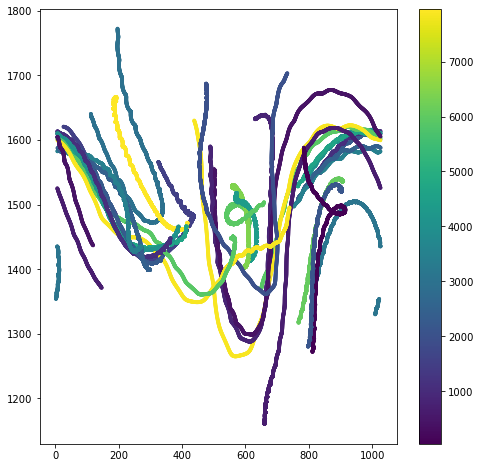

In [125]:
plt.figure(figsize=(8,8))
plt.scatter(S1[S1['id']%10==0].x.loc[1742:1757],S1[S1['id']%10==0].y.loc[1742:1757],c=S1[S1['id']%10==0].id.loc[1742:1757],s=8)
plt.colorbar()

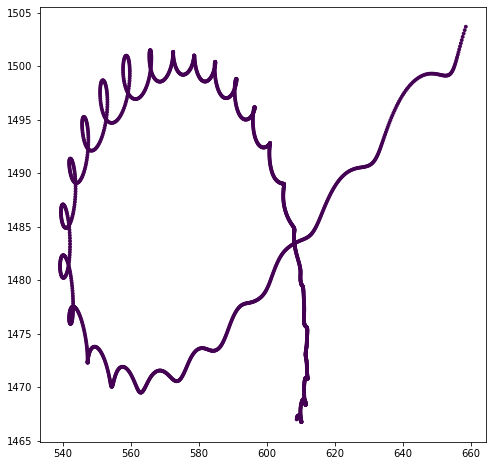

In [126]:
plt.figure(figsize=(8,8))
plt.scatter(S1[S1['id']==5930].x.loc[1742:1757],S1[S1['id']==5930].y.loc[1742:1757],c=S1[S1['id']==5930].id.loc[1742:1757],s=8)

In [43]:
KE = np.sqrt(ds.u**2+ds.v**2)

Text(0.5, 1.0, 'Time=1750 days')

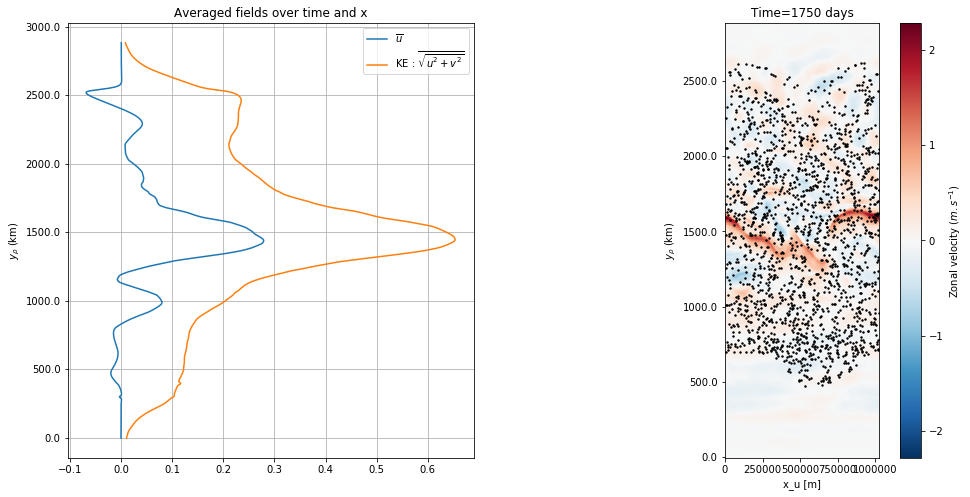

In [50]:
fig,axs = plt.subplots(1,2,figsize=(16,8))
ax = axs[0]
ds.u.mean(['time','x_rho']).plot(ax=ax,y='y_rho',label=r'$\overline{u}$')
KE.mean(['time','x_rho']).plot(ax=ax,y='y_rho',label=r'KE : $\overline{\sqrt{u^2+v^2}}$')
laby = ax.get_yticks();laby = [str(l*1e-3) for l in laby];
ax.set_yticklabels(laby)
ax.set_ylabel(r'$y_\rho$ (km)')#;ax.set_xlabel(r'$x_\rho$ (km)')
ax.grid();ax.legend();ax.set_title(r'Averaged fields over time and x')
ax = axs[1]
dsi.plot(ax=ax,cbar_kwargs={'label':r'Zonal velocity ($m.s^{-1}$)'})
laby = ax.get_yticks();laby = [str(l*1e-3) for l in laby];
ax.set_yticklabels(laby)
ax.set_ylabel(r'$y_\rho$ (km)')#;ax.set_xlabel(r'$x_\rho$ (km)')
#ax.plot(df.x.loc[t0:t1]*1e3,df.y.loc[t0:t1]*1e3)
#ax.plot(df.x.loc[t0]*1e3,df.y.loc[t0]*1e3,marker='o',color='r',markeredgecolor='w');
#ax.plot(df.x.loc[tmid]*1e3,df.y.loc[tmid]*1e3,marker='d',color='b',markeredgecolor='w')
ax.scatter(dfx[::4],dfy[::4],s=2,c='k')
ax.set_aspect('equal')
ax.set_title('Time=%s days'%1750)
#fig.savefig('/home1/datawork/zcaspar/Figs/drifters_simu.png')

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


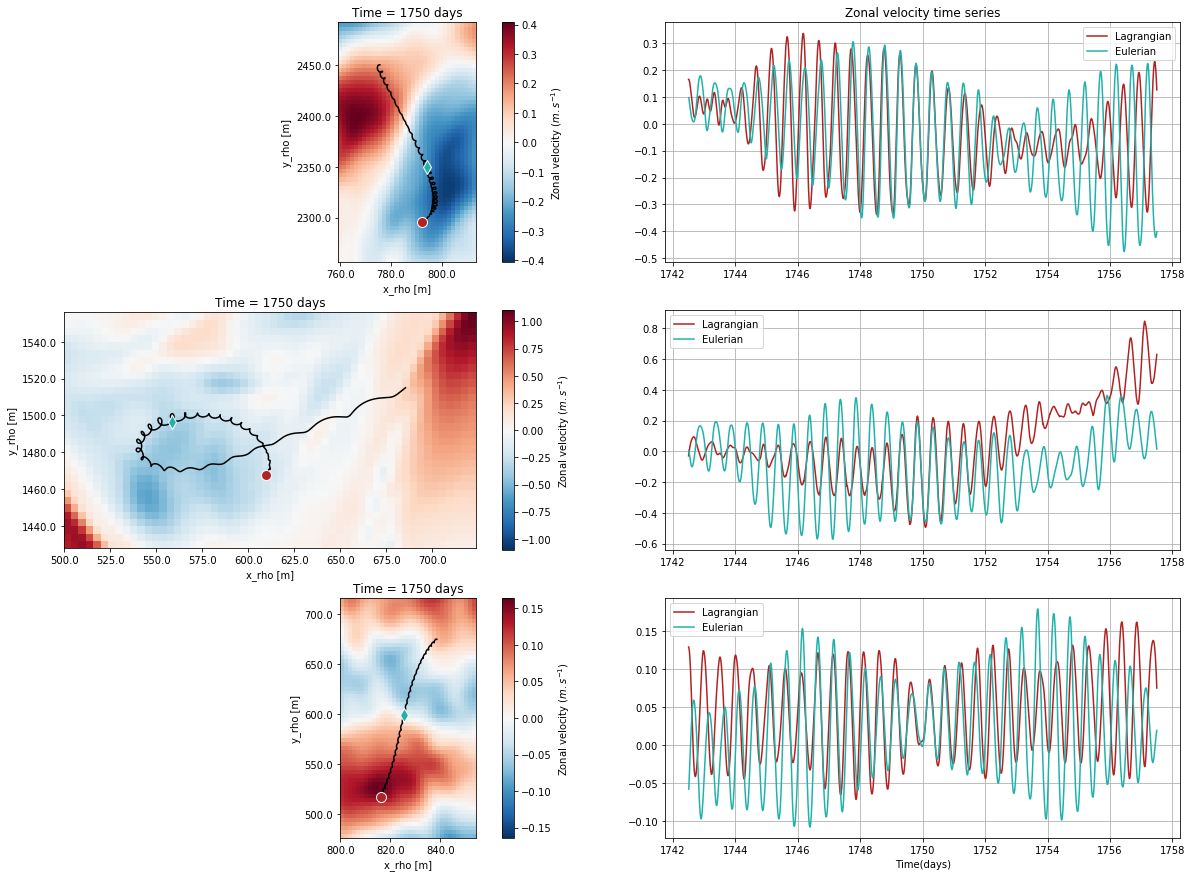

In [135]:
ce = 'lightseagreen'
cl = 'firebrick'
fig = plt.figure(figsize=(20,15))
grid = plt.GridSpec(3, 4, wspace=0.4, hspace=0.2)
for df,i in zip([df_north,df_jet,df_south],range(3)):
    df =df.sort_values('time').set_index('time')
    ds_zoom = ds.u.sel(x_rho = slice((df.x.loc[t0:t1].min()-40)*1e3,(df.x.loc[t0:t1].max()+40)*1e3),
                       y_rho = slice((df.y.loc[t0:t1].min()-40)*1e3,(df.y.loc[t0:t1].max()+40)*1e3)).persist()
    #ds_zoom = ds_zoom.isel(time=57*24*6).compute()
    ax = plt.subplot(grid[i,:2])
    ds_zoom.isel(time=250*24*6).plot(ax=ax,cbar_kwargs={'label':r'Zonal velocity ($m.s^{-1}$)'})#.isel(time=57*24*6).plot(ax=ax)
    labx,laby = ax.get_xticks(),ax.get_yticks();labx,laby = [str(l*1e-3) for l in labx],[str(l*1e-3) for l in laby];
    ax.set_xticklabels(labx);ax.set_yticklabels(laby)
    ax.plot(df.x.loc[t0:t1]*1e3,df.y.loc[t0:t1]*1e3,'k')
    ax.plot(df.x.loc[t0]*1e3,df.y.loc[t0]*1e3,marker='o',color=cl,markeredgecolor='w',ms=10);
    ax.plot(df.x.loc[tmid]*1e3,df.y.loc[tmid]*1e3,marker='d',color=ce,markeredgecolor='w',ms=10)
    ax.set_aspect('equal');ax.set_title('Time = %s days'%tmid)
    ax=plt.subplot(grid[i,2:])
    df.u.loc[t0:t1].plot(ax=ax,c=cl,label='Lagrangian')
    ds_zoom.sel(x_rho=df.x.loc[tmid]*1e3,y_rho=df.y.loc[tmid]*1e3,method='nearest').isel(time=slice(int(242.5*24*6),int(257.5*24*6))).plot(ax=ax,label='Eulerian',c=ce)
    ax.legend();ax.set_ylabel('');ax.grid();ax.set_xlabel('');ax.set_title('')
ax.set_xlabel('Time(days)');
ax=plt.subplot(grid[0,2:])
ax.set_title('Zonal velocity time series')
fig.tight_layout()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


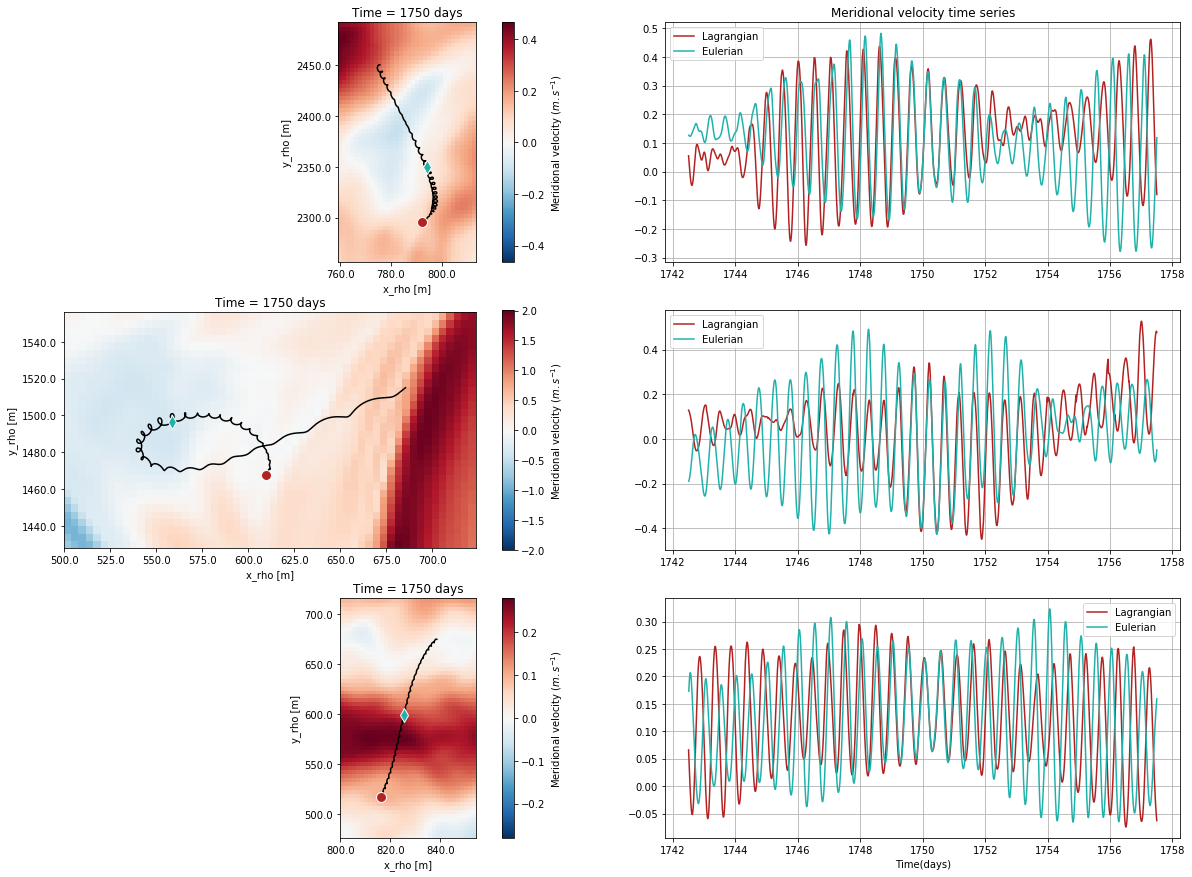

In [137]:
fig = plt.figure(figsize=(20,15))
grid = plt.GridSpec(3, 4, wspace=0.4, hspace=0.2)
for df,i in zip([df_north,df_jet,df_south],range(3)):
    df =df.sort_values('time').set_index('time')
    ds_zoom = ds.v.sel(x_rho = slice((df.x.loc[t0:t1].min()-40)*1e3,(df.x.loc[t0:t1].max()+40)*1e3),
                       y_rho = slice((df.y.loc[t0:t1].min()-40)*1e3,(df.y.loc[t0:t1].max()+40)*1e3)).persist()
    #ds_zoom = ds_zoom.isel(time=57*24*6).compute()
    ax = plt.subplot(grid[i,:2])
    ds_zoom.isel(time=250*24*6).plot(ax=ax,cbar_kwargs={'label':r'Meridional velocity ($m.s^{-1}$)'})#.isel(time=57*24*6).plot(ax=ax)
    labx,laby = ax.get_xticks(),ax.get_yticks();labx,laby = [str(l*1e-3) for l in labx],[str(l*1e-3) for l in laby];
    ax.set_xticklabels(labx);ax.set_yticklabels(laby)
    ax.plot(df.x.loc[t0:t1]*1e3,df.y.loc[t0:t1]*1e3,'k')
    ax.plot(df.x.loc[t0]*1e3,df.y.loc[t0]*1e3,marker='o',color=cl,markeredgecolor='w',ms=10);
    ax.plot(df.x.loc[tmid]*1e3,df.y.loc[tmid]*1e3,marker='d',color=ce,markeredgecolor='w',ms=10)
    ax.set_aspect('equal');ax.set_title('Time = %s days'%tmid)
    ax=plt.subplot(grid[i,2:])
    df.v.loc[t0:t1].plot(ax=ax,c=cl,label='Lagrangian')
    ds_zoom.sel(x_rho=df.x.loc[tmid]*1e3,y_rho=df.y.loc[tmid]*1e3,method='nearest').isel(time=slice(int(242.5*24*6),int(257.5*24*6))).plot(ax=ax,label='Eulerian',c=ce)
    ax.legend();ax.set_ylabel('');ax.grid();ax.set_xlabel('');ax.set_title('')
ax.set_xlabel('Time(days)');
ax=plt.subplot(grid[0,2:])
ax.set_title('Meridional velocity time series')
fig.tight_layout()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


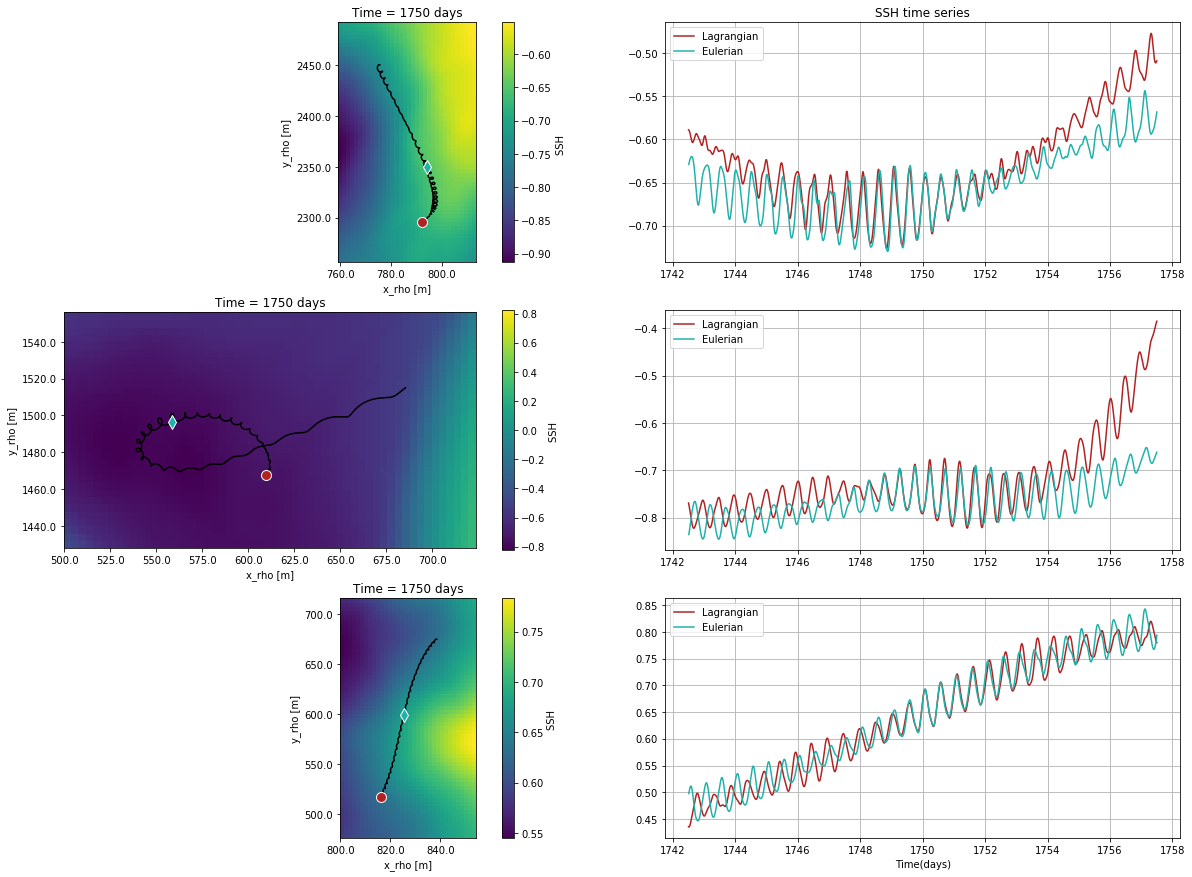

In [140]:
cmap = 'viridis'
fig = plt.figure(figsize=(20,15))
grid = plt.GridSpec(3, 4, wspace=0.4, hspace=0.2)
for df,i in zip([df_north,df_jet,df_south],range(3)):
    df =df.sort_values('time').set_index('time')
    ds_zoom = ds.ssh.sel(x_rho = slice((df.x.loc[t0:t1].min()-40)*1e3,(df.x.loc[t0:t1].max()+40)*1e3),
                       y_rho = slice((df.y.loc[t0:t1].min()-40)*1e3,(df.y.loc[t0:t1].max()+40)*1e3)).persist()
    #ds_zoom = ds_zoom.isel(time=57*24*6).compute()
    ax = plt.subplot(grid[i,:2])
    ds_zoom.isel(time=250*24*6).plot(ax=ax,cmap=cmap,cbar_kwargs={'label':r'SSH '})#.isel(time=57*24*6).plot(ax=ax)
    labx,laby = ax.get_xticks(),ax.get_yticks();labx,laby = [str(l*1e-3) for l in labx],[str(l*1e-3) for l in laby];
    ax.set_xticklabels(labx);ax.set_yticklabels(laby)
    ax.plot(df.x.loc[t0:t1]*1e3,df.y.loc[t0:t1]*1e3,'k')
    ax.plot(df.x.loc[t0]*1e3,df.y.loc[t0]*1e3,marker='o',color=cl,markeredgecolor='w',ms=10);
    ax.plot(df.x.loc[tmid]*1e3,df.y.loc[tmid]*1e3,marker='d',color=ce,markeredgecolor='w',ms=10)
    ax.set_aspect('equal');ax.set_title('Time = %s days'%tmid)
    ax=plt.subplot(grid[i,2:])
    df.depth.loc[t0:t1].plot(ax=ax,c=cl,label='Lagrangian')
    ds_zoom.sel(x_rho=df.x.loc[tmid]*1e3,y_rho=df.y.loc[tmid]*1e3,method='nearest').isel(time=slice(int(242.5*24*6),int(257.5*24*6))).plot(ax=ax,label='Eulerian',c=ce)
    ax.legend();ax.set_ylabel('');ax.grid();ax.set_xlabel('');ax.set_title('')
ax.set_xlabel('Time(days)');
ax=plt.subplot(grid[0,2:])
ax.set_title('SSH time series')
fig.tight_layout()


In [6]:
def diags_dist(v1,v2,v3,v4,N):
#    fltI = flt.sel(time=slice(Ti,Tf))
    if v1 is None and v2 is None:
        return pd.Series(np.random.randn(N),index=['xmax','xmin','ymax','ymin','y0','y1','dx','dy','ds'])
    else : 
        dxint = np.abs(v3).mean()#np.diff(np.unwrap(v1)).sum()
        dyint = np.abs(v4).mean()#np.diff(v2).sum()
        dsint = np.sqrt(v3**2+v4**2).mean()#np.diff(np.unwrap(v1))**2+np.diff(v2)**2).sum()
        return pd.Series([np.unwrap(v1).max(),np.unwrap(v1).min(),v2.max(),v2.min(),v2.iloc[0],v2.iloc[-1],dxint,dyint,dsint],
                         index=['xmax','xmin','ymax','ymin','y0','y1','dx','dy','ds'])#,fltI.v

In [7]:
def apply_window(myfun,columns,T,N,L,binsize):
    """Compute diags_dist and returns xarray"""
    df_chunked = dr.df.groupby(dr.df.index).apply(cdr.time_window_processing, myfun, 
                                                  columns,T,N,L
                                                 )#.persist()
    y_bins = np.arange(0,2800,binsize)
    y_idx = pd.IntervalIndex.from_breaks(y_bins)
    df_chunked['y0_cut'] = df_chunked['y0'].map_partitions(pd.cut, bins=y_bins)
    df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )
    # difference btw y max and min
    df_chunked['ydiff'] = df_chunked['ymax']-df_chunked['ymin']
    # difference btw x max and min
    df_chunked['xdiff'] = df_chunked['xmax']-df_chunked['xmin']
    DF = df_chunked.compute()
    return DF.set_index(DF.y0_cut.map(lambda v: v.mid)).drop(columns=['time','x','y']).rename(columns={'y0_cut':'y0_bins'}).to_xarray()

In [ ]:
ds_dist = {}
for T in [10,20,40,80,120]:
    ds_dist['ds_'+str(T)] = apply_window(diags_dist,['x','y','u','v'],T,9,1024,50)
#ds40 = apply_window(diags_dist,['x','y','u','v'],40,9,L,50)
#ds20 = apply_window(diags_dist,['x','y','u','v'],20,9,L,50)
#ds10 = apply_window(diags_dist,['x','y','u','v'],10,9,L,50)
#ds80 = apply_window(diags_dist,['x','y','u','v'],80,9,L,50)
#ds120 = apply_window(diags_dist,['x','y','u','v'],120,9,L,50)

In [10]:
ds_stats={}
for T in ['10','20','40','80','120']:
    ds_stats[T] = ds_dist['ds_'+str(T)].groupby('y0_cut').mean()
    ds_stats[T]['Tu'] = (float(T)*24*3600*ds_stats[T].dx*1e-3)
    ds_stats[T]['Tv'] = (float(T)*24*3600*ds_stats[T].dy*1e-3)

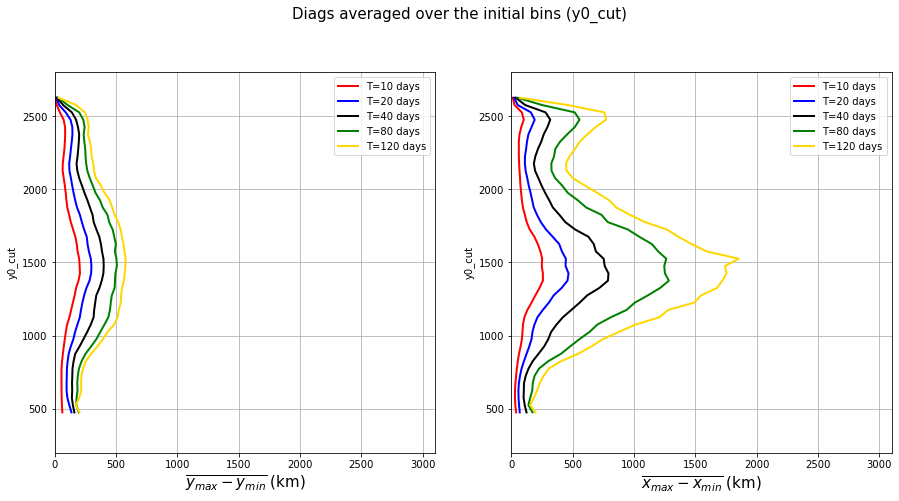

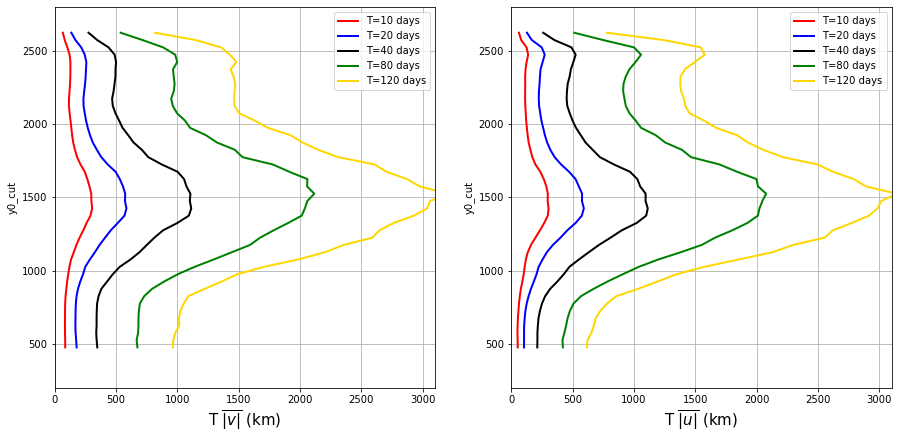

In [14]:
fontsize = 15
number = len(['10','20','40','80','120'])
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, number)]

fig,axs = plt.subplots(1,2,figsize=(15,7))
fig.suptitle('Diags averaged over the initial bins (y0_cut)',x=0.5,y=1.01,fontsize=fontsize)
for T,c in zip(ds_stats.keys(),colors):
    for var,lab,ax in zip(['ydiff','xdiff'],[r'$\overline{y_{max}-y_{min}}$ (km)',r'$\overline{x_{max}-x_{min}}$ (km)'],axs):
        ds_stats[T][var].plot(y='y0_cut',ax=ax,c=c,linewidth=2,label='T=%s days'%int(T))
        ax.set_xlabel(lab,fontsize=fontsize)
        ax.legend()
        ax.set_xlim(0,3100);ax.set_ylim(200,2800)
axs[0].grid();axs[1].grid()
fig,axs = plt.subplots(1,2,figsize=(15,7))
for T,c in zip(ds_stats.keys(),colors):
    for var,lab, ax in zip(['Tv','Tu'],[r'T $\overline{|v|}$ (km)',r'T $\overline{|u|}$ (km)'],axs):
        ds_stats[T][var].plot(y='y0_cut',ax=ax,c=c,linewidth=2,label='T=%s days'%int(T))
        ax.legend()
        ax.set_xlim(0,3100);ax.set_ylim(200,2800)
        ax.set_xlabel(lab,fontsize=fontsize)
axs[0].grid();axs[1].grid()

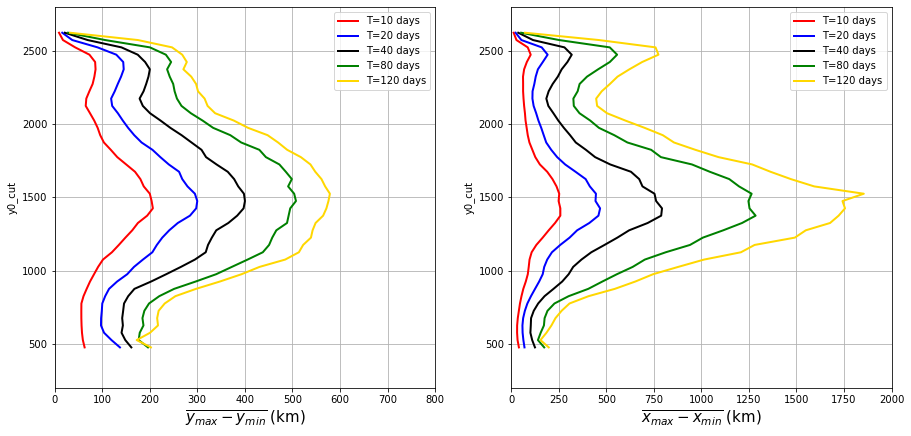

In [18]:
fig,axs = plt.subplots(1,2,figsize=(15,7))

for T,c in zip(ds_stats.keys(),colors):
    for var,lab,ax in zip(['ydiff','xdiff'],[r'$\overline{y_{max}-y_{min}}$ (km)',r'$\overline{x_{max}-x_{min}}$ (km)'],axs):
        ds_stats[T][var].plot(y='y0_cut',ax=ax,c=c,linewidth=2,label='T=%s days'%int(T))
        ax.set_xlabel(lab,fontsize=fontsize)
        ax.legend()
        ax.set_ylim(200,2800)
        ax.grid()
axs[0].set_xlim(0,800);axs[1].set_xlim(0,2000);

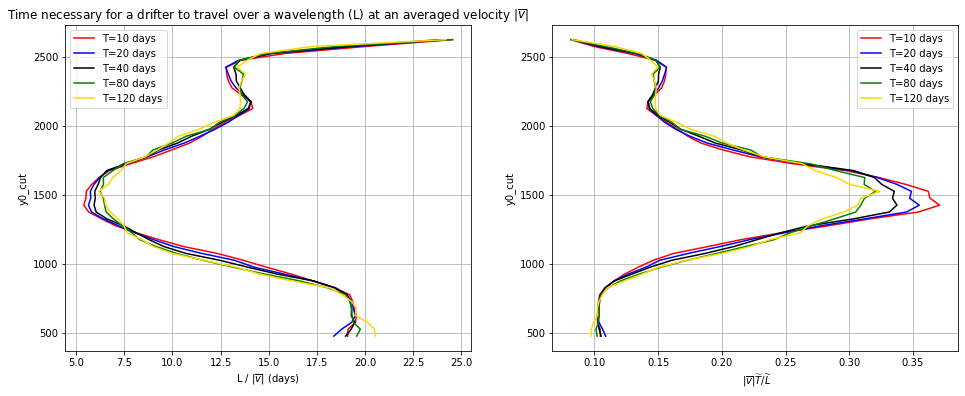

In [20]:
Lbc = 165
Tw = 2
fig, ax = plt.subplots(1,2,figsize=(16,6))
for T, c in zip(ds_stats.keys(),colors):
    (Lbc/(24*3600*ds_stats[T].dy*1e-3)).plot(ax=ax[0],y='y0_cut',c=c,label='T=%s days'%int(T))
ax[0].grid();ax[0].set_xlabel(r'L / $\vert\overline{v}\vert$ (days)')
ax[0].set_title(r'Time necessary for a drifter to travel over a wavelength (L) at an averaged velocity $\vert\overline{v}\vert$')
ax[0].legend()
#Tbc = (Lbc/(ds80_stats.dy*1e-3))/24*3600
#Tbc2 = (Lbc/(2*ds80_stats.dy*1e-3))/24*3600

for T, c in zip(ds_stats.keys(),colors):
    (Tw*(24*3600*ds_stats[T].dy*1e-3)/Lbc).plot(ax=ax[1],y='y0_cut',c=c,label='T=%s days'%int(T))
ax[1].grid();ax[1].set_xlabel(r' $\vert\overline{v}\vert\widetilde{T}/\widetilde{L}$')
#ax.set_title(r'Time necessary for a drifter to travel over a wavelength (L) at an averaged velocity $\vert\overline{v}\vert$')
ax[1].legend()

### Autocorrelations T=40days

In [2]:
#path = '/home/datawork-lops-osi/equinox/jetn/old/jet_cfg1_wp75_4km_1500a2000j_itide/diagnostics/' #datarmor
path = '/Users/zcaspar/codes/Diagnostics/'#local

In [3]:
corrE = {}
removed = ['avg1d','total']
for name,data in zip(removed,['ZC_Eulerian_corr_40avg1d.nc','ZC_Eulerian_corr_40total.nc']):
    corrE[name] = xr.open_dataset(path+data).rename({'lags':'lag'})
    for v in ['uu', 'vv']:
        corrE[name][v+'_normalized'] = corrE[name][v]/corrE[name][v].sel(lag=0)
    for v in ['uv']:#
        corrE[name][v+'_normalized'] = corrE[name][v]/np.sqrt(corrE[name]['uu'].sel(lag=0)*corrE[name]['vv'].sel(lag=0))

In [4]:
corrL = {}
removed = ['avg1d','total']
for name,data in zip(removed,
                     ['ZC_drifters_corr_40avg1d.nc','ZC_drifters_corr_40total.nc']):
    corrL[name] = xr.open_dataset(path+data)
    for v in ['uu', 'vv']:
        corrL[name][v+'_normalized'] = corrL[name][v]/corrL[name][v].sel(lag=0)
    for v in ['uv', 'vu']:
        corrL[name][v+'_normalized'] = corrL[name][v]/np.sqrt(corrL[name]['uu'].sel(lag=0)*corrL[name]['vv'].sel(lag=0))

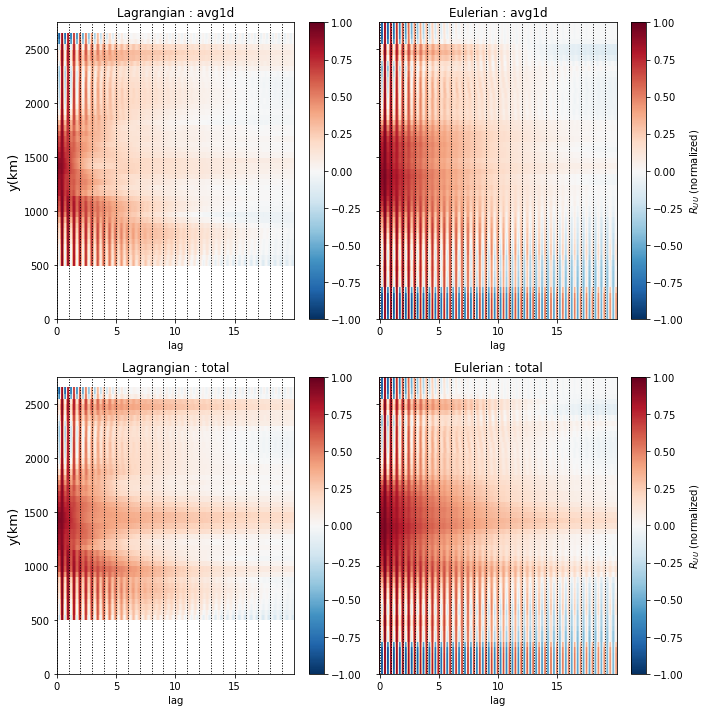

In [5]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
for V,i in zip(['avg1d','total'],range(2)):
    corrL[V]['uu_normalized'].plot(ax=ax[i,0],cbar_kwargs={'label':''});ax[i,0].set_ylabel('')
    corrE[V]['uu_normalized'].plot(ax=ax[i,1],cbar_kwargs={'label':r'$R_{UU}$ (normalized)'});ax[i,1].set_ylabel('')
    [ax[i,0].axvline(x,linestyle='dotted',color='k',linewidth=1) for x in np.arange(0,20,2*0.5)]
    ax[i,0].set_title('Lagrangian : '+V);ax[i,0].set_ylabel('y(km)',fontsize=13)
    [ax[i,1].axvline(x,linestyle='dotted',color='k',linewidth=1) for x in np.arange(0,20,2*0.5)]
    ax[i,1].set_title('Eulerian : '+V);ax[i,1].set_yticklabels('')#;ax[i,1].set_ylabel('y(m)',fontsize=15)
fig.tight_layout()
#    ax[i,1].set_xlim(0,10);ax[i,0].set_xlim(0,10)

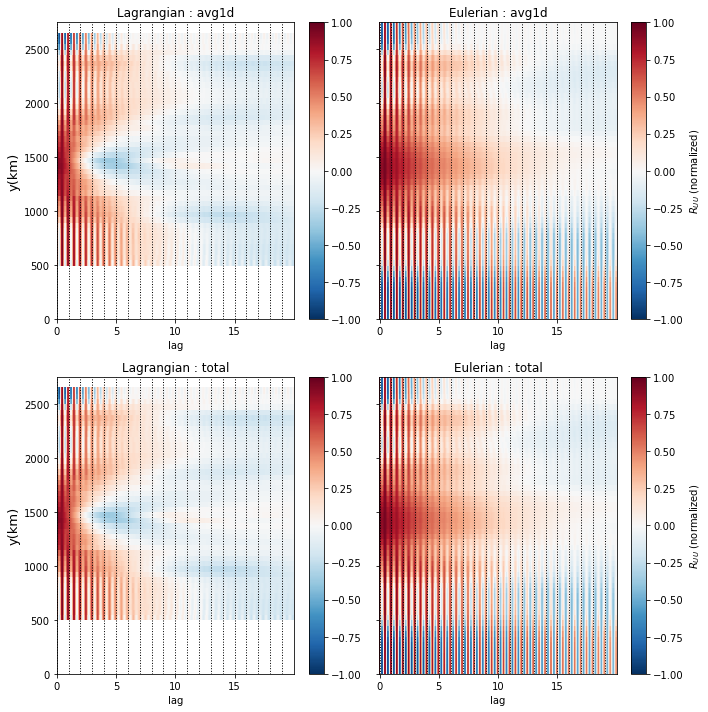

In [6]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
for V,i in zip(['avg1d','total'],range(2)):
    corrL[V]['vv_normalized'].plot(ax=ax[i,0],cbar_kwargs={'label':''});ax[i,0].set_ylabel('')
    corrE[V]['vv_normalized'].plot(ax=ax[i,1],cbar_kwargs={'label':r'$R_{UU}$ (normalized)'});ax[i,1].set_ylabel('')
    [ax[i,0].axvline(x,linestyle='dotted',color='k',linewidth=1) for x in np.arange(0,20,2*0.5)]
    ax[i,0].set_title('Lagrangian : '+V);ax[i,0].set_ylabel('y(km)',fontsize=13)
    [ax[i,1].axvline(x,linestyle='dotted',color='k',linewidth=1) for x in np.arange(0,20,2*0.5)]
    ax[i,1].set_title('Eulerian : '+V);ax[i,1].set_yticklabels('')#;ax[i,1].set_ylabel('y(m)',fontsize=15)
fig.tight_layout()

### Fit

Mettre figures résultats fit eulerién lagrangien avec intervalles de confiance (bootstrap)

$\widetilde{C} = \widetilde{X}cos(\omega\tau)e^{-\tau/\tilde{T}}$\
$\overline{C} = \overline{X}cos(\Omega\tau)e^{-\tau/\bar{T}}$\
$C = \widetilde{C}+\overline{C}$

In [22]:
om = 2 # tidal frequency (M2)
# Fast contribution
def Ctilde(t,Tt):
    return np.exp(-t/Tt)*np.cos(2*np.pi*om*t)#*np.cos(2*np.pi*nu*t)
#Slow contribution
def Cbar(t,Tb):
    return np.exp(-t/Tb)#*np.cos(2*np.pi*Om*t)
#Total formula
def C(t,Tt,Xtilde,Tb,Xbar):
    return Xbar*Cbar(t,Tb)+Xtilde*Ctilde(t,Tt)

In [23]:
def fit(t,y,myfunc,bounds,norm=False): 
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        t : timelag of the correlation function
        y : data to fit
        myfunc : function we want to fit to our data, y
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        yfit : best fit
        params : parameters for which we obtain the best fit
        cov : covariance of params computed in scipy.optimize.curve_fit
        """
    sig = signature(myfunc)
    if norm:
        y = y/y.sel(lag=0)
    if np.isnan(y).any()==True:
        yfit = np.full_like(y,np.nan)
        params=np.full(len([V for V in sig.parameters.keys()][1:]),np.nan)
        cov = np.full((len([V for V in sig.parameters.keys()][1:]),len([V for V in sig.parameters.keys()][1:])),np.nan)
        yfit = xr.DataArray(np.full(y.lag.size,np.nan))
    else : 
        params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds)#,sigma=weights,absolute_sigma=True)
        yfit = myfunc(t,*[p for p in params])
    out = xr.Dataset({'params':(['ybin','param'],np.expand_dims(params, axis=0)),
                      'fitted':(['ybin','lags'],np.expand_dims(yfit.values,axis=0))},
                     coords={'ybin':np.array([y.y_bins.values]),'param':[V for V in sig.parameters.keys()][1:],
                             'lags':y.lag.values})
    return out#yfit,params,cov

In [24]:
from inspect import signature
import scipy


# Parameters
myfunc = C #function to use for the fit
bounds = ((1,0,0,0),np.inf) # bounds for the fit to avoid non physical results

In [28]:
out_combL_avg,out_combE_avg = {},{}
for V in ['uu','vv'] :
    out_combL_avg[V] = xr.concat([fit(corrL['avg1d'][V].lag,corrL['avg1d'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrL['avg1d'][V].y_bins],dim='ybin')
    out_combE_avg[V] = xr.concat([fit(corrE['avg1d'][V].lag,corrE['avg1d'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrE['avg1d'][V].y_bins],dim='ybin')

In [29]:
for V in ['uu','vv'] :
    out_combE_avg[V] = out_combE_avg[V].assign_coords({'ybin':out_combE_avg[V].ybin.values*1e-3})

In [30]:
for V in ['uu','vv']:
    out_combE_avg[V+'_normalized'] = out_combE_avg[V].fitted/out_combE_avg[V].fitted.sel(lags=0)
    out_combL_avg[V+'_normalized'] = out_combL_avg[V].fitted/out_combL_avg[V].fitted.sel(lags=0)

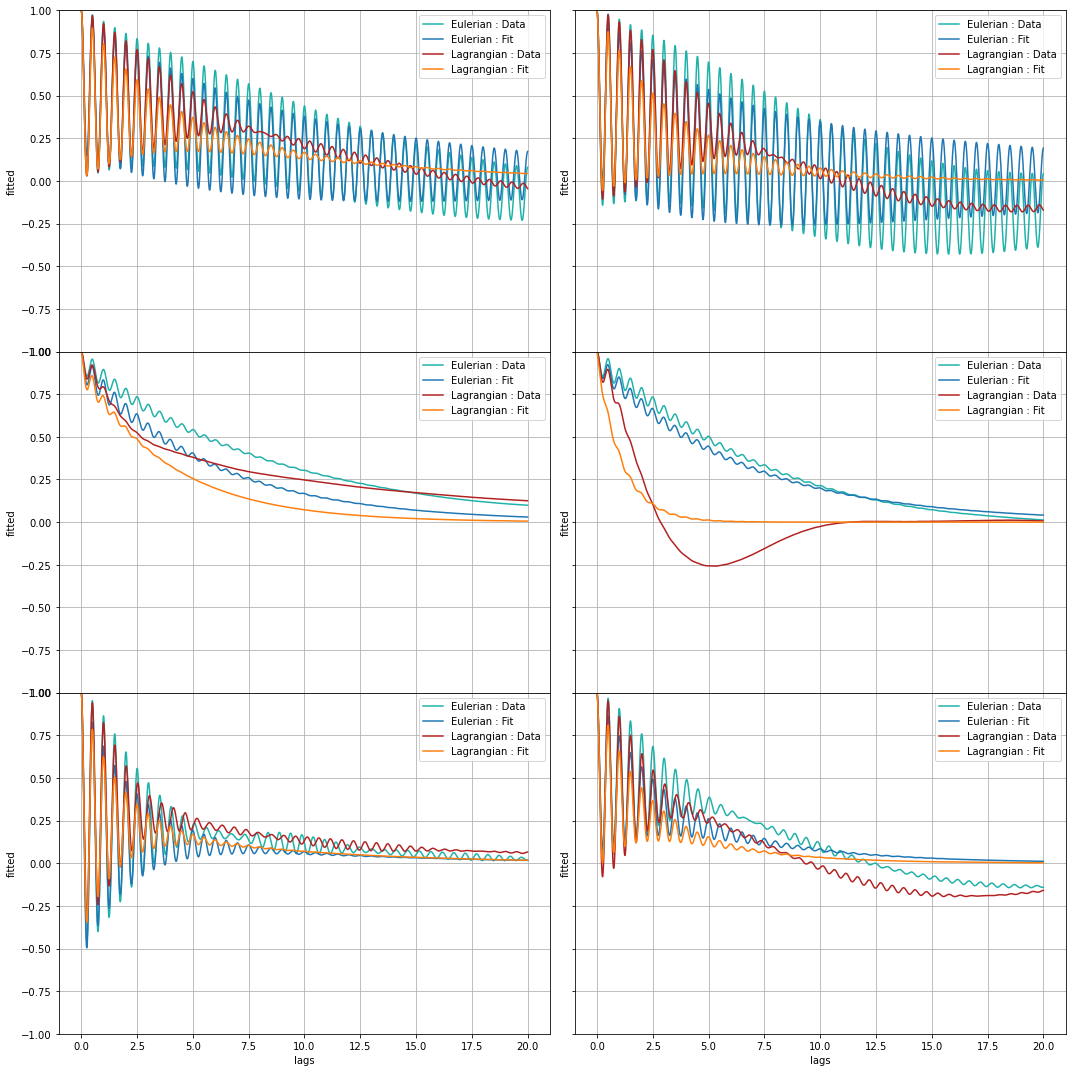

In [31]:
#Sections
Y=[700,1500,2300]
fig,axs = plt.subplots(3,2,figsize=(15,15),sharex=True, sharey=True,gridspec_kw={'hspace': 0})
for i,y in enumerate(Y):
    for V,ax in zip(['uu','vv'],axs[i,:]):
        corrE[name][V+'_normalized'].sel(y_bins=y*1e3,method='nearest').plot(c=ce,ax=ax,label=('Eulerian : Data'))
        out_combE_avg[V+'_normalized'].sel(ybin=y,method='nearest').plot(ax=ax,label=('Eulerian : Fit'))
        corrL[name][V+'_normalized'].sel(y_bins=y,method='nearest').plot(c=cl,ax=ax,label=('Lagrangian : Data'))
        out_combL_avg[V+'_normalized'].sel(ybin=y,method='nearest').plot(ax=ax,label=('Lagrangian : Fit'))
        ax.set_ylim(-1,1);ax.grid();ax.legend();ax.set_title('')
    #axs[0].text(-4,0,name,fontsize=20,rotation=90)
    #axs[0].set_title('uu');axs[1].set_title('vv')#;axs[0,2].set_title('uv');axs[0,3].set_title('vu')
    #plt.suptitle(title,x=.55,y=1,fontsize=20)
    fig.tight_layout()

In [ ]:
#Sections
Y=[700,1500,2300]
for y,title in zip(Y,['South','In the jet','North']):
    fig,axs = plt.subplots(1,2,figsize=(10,5))
    for V,ax in zip(['uu','vv'],axs[:]):
        corrE['avg1d'][V].sel(y_bins=y*1e3,method='nearest').plot(ax=ax,label=('Data'))
        out_combE_avg[V].fitted.sel(ybin=y,method='nearest').plot(ax=ax,label=('Fit'))
        
        #out_combL_avg[V].fitted.sel(ybin=y*1e-3,method='nearest').plot(linestyle='--',ax=ax,label=('Lagrangian'))
        #ax.set_xlim(0,10);ax.set_ylim(-1,1);ax.grid();ax.legend()
        ax.legend()
    axs[0].set_title('uu');axs[1].set_title('vv')#;axs[0,2].set_title('uv');axs[0,3].set_title('vu')
    plt.suptitle(title,x=.55,y=1,fontsize=20)
    fig.tight_layout()

In [ ]:
#Sections
Y=[700,1500,2300]
for y,title in zip(Y,['South','In the jet','North']):
    fig,axs = plt.subplots(1,2,figsize=(10,5))
    for V,ax in zip(['uu','vv'],axs[:]):
        corrL['avg1d'][V].sel(y_bins=y,method='nearest').plot(ax=ax,label=('Data'))
        out_combL_avg[V].fitted.sel(ybin=y,method='nearest').plot(ax=ax,label=('Fit'))
        
        #out_combL_avg[V].fitted.sel(ybin=y*1e-3,method='nearest').plot(linestyle='--',ax=ax,label=('Lagrangian'))
        #ax.set_xlim(0,10);ax.set_ylim(-1,1);ax.grid();ax.legend()
        ax.legend()
    axs[0].set_title('uu');axs[1].set_title('vv')#;axs[0,2].set_title('uv');axs[0,3].set_title('vu')
    plt.suptitle(title,x=.55,y=1,fontsize=20)
    fig.tight_layout()

In [33]:
lims_uu = [(0,25),(0,0.3),(0,25),(0,0.5)]#,(-0.01,0.05)]
lims_vv = [(0,25),(0,0.1),(0,25),(0,0.8)]#,(-0.01,0.07)]
titles = [r'$\widetilde{T}$',r'$\widetilde{X}$',r'$\overline{T}$',r'$\overline{X}$']#,r'$\Omega$']

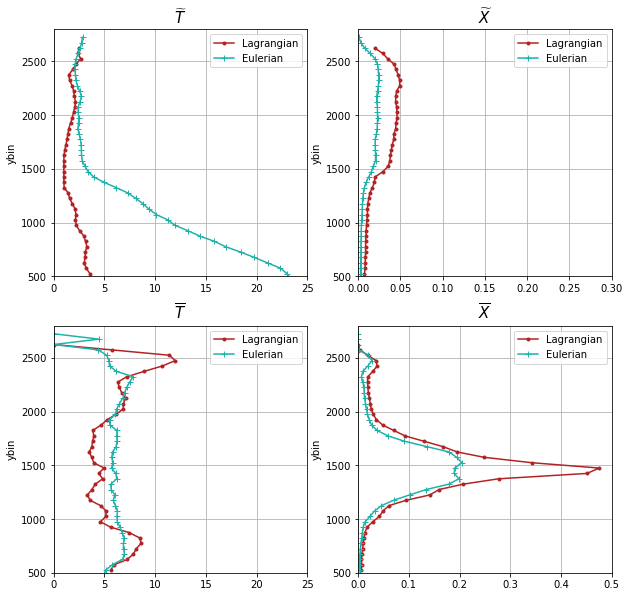

In [34]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims_uu[:2],axes[0,:]):
    out_combL_avg['uu'].params.sel(param=pa).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['uu'].params.sel(param=pa).plot(y='ybin',c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Tb','Xbar'],titles[2:],lims_uu[2:],axes[1,:]):
    out_combL_avg['uu'].params.sel(param=pa).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['uu'].params.sel(param=pa).plot(y='ybin', c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)


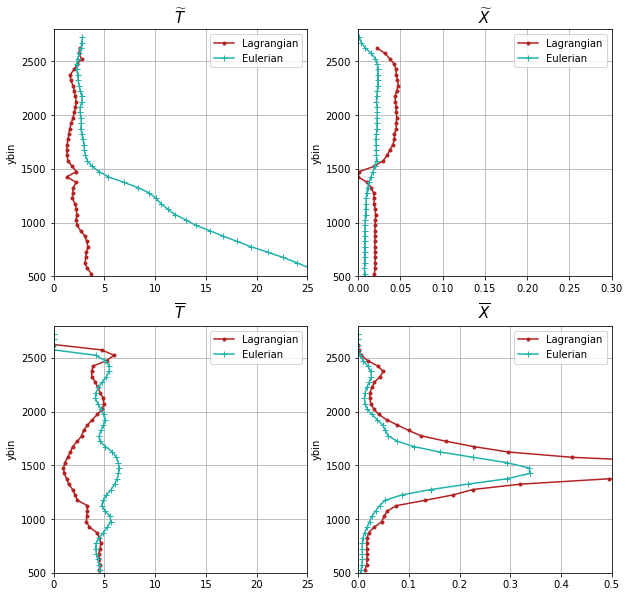

In [206]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims_uu[:2],axes[0,:]):
    out_combL_avg['vv'].params.sel(param=pa).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['vv'].params.sel(param=pa).plot(y='ybin',c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Tb','Xbar'],titles[2:],lims_uu[2:],axes[1,:]):
    out_combL_avg['vv'].params.sel(param=pa).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['vv'].params.sel(param=pa).plot(y='ybin', c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)

In [141]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
